# Audio Processing - 2

## Content
1. Automatic Speech Recognition with CNN
1. Automatic Speech Recognition with RNN
1. Speech Emotion Recogntion with LSTM
1. Feature Extraction with Wav2vec2.0


# Automatic Speech Recognition with CNN

In [2]:
# Set up the Dataset by downloading
!chmod +x download_speech_commands.sh
!./download_speech_commands.sh

1044.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1049.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-06-20 03:09:10--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.24.59, 2404:6800:4006:804::201b
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.24.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  15.5MB/s    in 97s     

2024-06-20 03:10:47 (14.6 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Deleting folder: _background_noise_
Deleting folder: bed
Deleting folder: bird
Deleting folder: cat
Deleting folder: dog
Deleting folder: down
Keeping folder: eight
Keeping folder: five
Keeping folder: four
Deleting folder: go
Deleting folder: happy
Deleting folder: house
Deleting folder: left
Deleting folder: marvin
Keeping folder: nine
Deleting folder: no
Deleting folder: off
Deleting folder: o

In [5]:
!ls -l "./speech_commands/0" | wc -l 

1290.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


201


In [10]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import librosa
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

In [11]:
# Create the Dataset Class with DatasetFolder
class SpeechCommandsDataset(DatasetFolder): 
    def __init__(self, root):
        super().__init__(root, loader=self.load_audio, extensions='.wav' )

    def load_audio(self, path):
        audio, sr = librosa.load(path)
        audio = librosa.util.fix_length(audio, size= 1 * sr)
        spec = librosa.feature.melspectrogram(y=audio, sr=sr) # 128x44
        spec = np.expand_dims(spec, 0) # 1x128x44
        spec = torch.from_numpy(spec)
        return spec

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        return sample, target

In [14]:
batch_size = 64
# Load the Dataset
dataset = SpeechCommandsDataset(root="./speech_commands")

# Split in to testing, validation and training sets

train_len = int(0.7*len(dataset))
val_len = int(0.2*len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# Explore the input shapes
s, l = next(iter(train_loader))
print(s.shape)
print(l)

torch.Size([64, 1, 128, 44])
tensor([6, 4, 9, 3, 6, 7, 9, 1, 6, 9, 8, 1, 5, 9, 4, 5, 1, 8, 9, 7, 2, 6, 6, 9,
        2, 3, 8, 6, 3, 1, 6, 1, 8, 5, 5, 0, 2, 4, 3, 4, 1, 5, 7, 2, 8, 2, 9, 4,
        6, 8, 5, 2, 9, 7, 0, 5, 3, 9, 5, 1, 3, 6, 8, 5])


In [28]:
# Create a CNN model
class ASRCNN(nn.Module):
    def __init__(self):
        super(ASRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*32*11, 256) 
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*32*11) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ASRCNN()


In [20]:
print(model)

ASRCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=22528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [21]:
# Create Train function
def train(model, device, train_loader, optimizer, criterion, epoch, train_history, val_history):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_history.append((train_loss, accuracy))
    print(f'Train Epoch: {epoch} Average loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.0f}%)')


# Create eval function

def evaluate(model, device, val_loader, criterion, val_history):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_history.append((val_loss, accuracy))
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.0f}%)')

# Create testing function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return all_preds, all_targets, test_loss, accuracy


In [31]:
# get the cuda/cpu device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# transfer the model to device
model = model.to(device)

# set-up optimiser and loss fn
optimiser = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_history, val_history = [] , []

# train for n epochs
n_epochs = 5
for epoch in range(1,n_epochs+1):
    train(model, device, train_loader, optimiser, loss_fn, epoch, train_history, val_history)
    evaluate(model, device, val_loader, loss_fn, val_history)


Train Epoch: 1 Average loss: 0.0277, Accuracy: 706/1400 (50%)
Validation set: Average loss: 0.0427, Accuracy: 153/400 (38%)
Train Epoch: 2 Average loss: 0.0209, Accuracy: 855/1400 (61%)
Validation set: Average loss: 0.0469, Accuracy: 173/400 (43%)
Train Epoch: 3 Average loss: 0.0177, Accuracy: 997/1400 (71%)
Validation set: Average loss: 0.0655, Accuracy: 199/400 (50%)
Train Epoch: 4 Average loss: 0.0177, Accuracy: 989/1400 (71%)
Validation set: Average loss: 0.0658, Accuracy: 165/400 (41%)
Train Epoch: 5 Average loss: 0.0133, Accuracy: 1093/1400 (78%)
Validation set: Average loss: 0.0670, Accuracy: 182/400 (46%)


Test set: Average loss: 0.0688, Accuracy: 87/200 (44%)



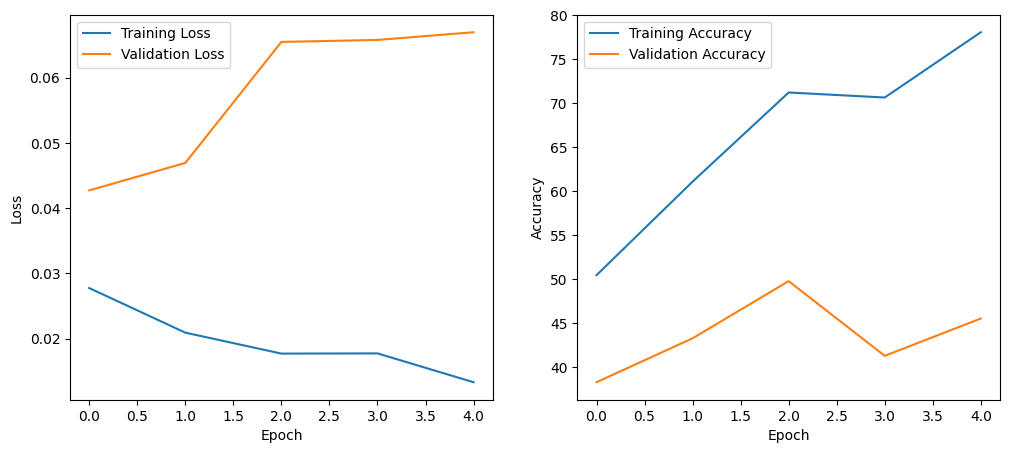

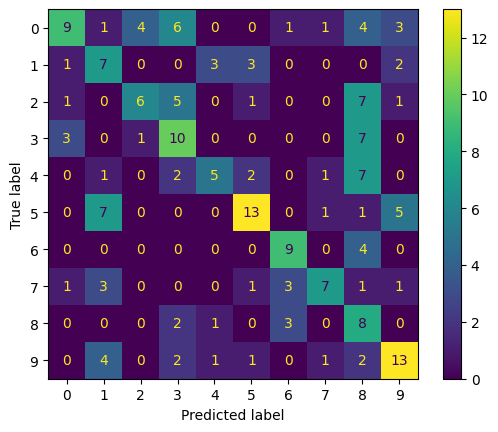

In [35]:
# Evaluate on test
all_preds, all_targets, test_loss, accuracy = test(model, device, test_loader, loss_fn)

# visualise loss and accuracy
train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# visualise confusion matrix
cm = confusion_matrix(all_targets, all_preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()



# Automatic Speech Recognition with RNN

In [37]:
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import glob
import numpy as np

In [41]:
# Create Dataset Class
class SpeechCommandsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.files = glob.glob(data_dir + '/*/*.wav')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = file_path.split('/')[-2]
        waveform, sample_rate = librosa.load(file_path)
        waveform = librosa.util.fix_length(waveform, size=1 * sample_rate)
        waveform = torch.from_numpy(waveform)
        if self.transform:
            waveform = self.transform(waveform)
        label = self.classes.index(label)
        return waveform, label

# Add Transforms https://pytorch.org/audio/stable/transforms.html
transform = T.Resample(orig_freq=22050, new_freq=8000)

# Create Dataset
dataset = SpeechCommandsDataset('./speech_commands', transform=transform)

# Split in to train val and test subsets
train_len = int(0.7 * len(dataset))
val_len = int(0.2 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])


# Create Loaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
# Explore the data
d,l = next(iter(train_loader))
d.shape

torch.Size([64, 8000])

In [43]:
# Create a RNN Model
class RNN_ASR(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_ASR, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out


input_size = 8000  # Number of features
hidden_size = 128
output_size = len(dataset.classes)  # Number of classes -> 10

model = RNN_ASR(input_size, hidden_size, output_size).to(device)


In [45]:
# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# setup optimiser and loss fn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train for n epochs

num_epochs = 10

for epoch in range(num_epochs):
    for i, (waveforms, labels) in enumerate(train_loader):
        waveforms = waveforms.squeeze(1).to(device) 
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms = waveforms.to(device)
            labels = labels.to(device)
            
            outputs = model(waveforms)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Val Accuracy: {100 * correct / total:.2f}%")



Epoch [1/10], Step [10/22], Loss: 2.6307
Epoch [1/10], Step [20/22], Loss: 2.5044
Val Accuracy: 13.00%
Epoch [2/10], Step [10/22], Loss: 2.2756
Epoch [2/10], Step [20/22], Loss: 2.1001
Val Accuracy: 11.25%
Epoch [3/10], Step [10/22], Loss: 1.8801
Epoch [3/10], Step [20/22], Loss: 1.9174
Val Accuracy: 11.25%
Epoch [4/10], Step [10/22], Loss: 1.6986
Epoch [4/10], Step [20/22], Loss: 1.6298
Val Accuracy: 11.50%
Epoch [5/10], Step [10/22], Loss: 1.5097
Epoch [5/10], Step [20/22], Loss: 1.3573
Val Accuracy: 11.50%
Epoch [6/10], Step [10/22], Loss: 1.2288
Epoch [6/10], Step [20/22], Loss: 1.4892
Val Accuracy: 9.75%
Epoch [7/10], Step [10/22], Loss: 1.3252
Epoch [7/10], Step [20/22], Loss: 1.0766
Val Accuracy: 11.50%
Epoch [8/10], Step [10/22], Loss: 1.0993
Epoch [8/10], Step [20/22], Loss: 0.9803
Val Accuracy: 11.00%
Epoch [9/10], Step [10/22], Loss: 0.8608
Epoch [9/10], Step [20/22], Loss: 0.9750
Val Accuracy: 11.50%
Epoch [10/10], Step [10/22], Loss: 0.9048
Epoch [10/10], Step [20/22], Los

In [46]:
# Test with testing dataset

correct = 0
total = 0

with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)

        outputs = model(waveforms)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test dataset: {100 * correct / total:.2f}%')



Accuracy of the model on the test dataset: 11.00%


# Speech Emotion Recogntion with LSTM

In [ ]:
!mkdir iemocap
!cp "/content/drive/MyDrive/CSC6203/Data/Iemocap_lite/testing.zip" "/content/iemocap/testing.zip"
!unzip "/content/iemocap/testing.zip" -d "/content/iemocap/testing"
!rm -rf "/content/iemocap/testing/__MACOSX"
!mv "/content/iemocap/testing" "/content/iemocap/testing_"
!mv "/content/iemocap/testing_/testing" "/content/iemocap/testing"
!rm -rf "/content/iemocap/testing_"

!cp "/content/drive/MyDrive/CSC6203/Data/Iemocap_lite/training.zip" "/content/iemocap/training.zip"
!unzip "/content/iemocap/training.zip" -d "/content/iemocap/training"
!rm -rf "/content/iemocap/training/__MACOSX"
!mv "/content/iemocap/training" "/content/iemocap/training_"
!mv "/content/iemocap/training_/training" "/content/iemocap/training"
!rm -rf "/content/iemocap/training_"

In [48]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import DatasetFolder

In [51]:
def load_npy(path):
    return np.load(path).astype(np.float32)

# Load the Dataset
batch_size = 32

training_dataset = DatasetFolder(root="./iemocap/training",
                                     loader=load_npy,
                                     extensions=".mfcc.npy")
classes, class_to_idx = training_dataset.find_classes(directory="./iemocap/training")

testing_dataset = DatasetFolder(root="./iemocap/testing",
                                     loader=load_npy,
                                     extensions=".mfcc.npy")



# Split in to 2 sub sets

train_size = int(0.8 * len(training_dataset))
val_size = len(training_dataset) - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


In [52]:
# explore the dataset
class_to_idx
m,l = next(iter(train_loader))
m.shape

torch.Size([32, 128, 130])

In [54]:
# Create LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last output of the sequence
        return out



In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, optimizer
input_size = m.shape[2]
hidden_size = 128
num_layers = 2
num_classes = 4

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
model

LSTMModel(
  (lstm): LSTM(130, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [63]:
# Train for n epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.float()  # Ensure inputs are of type float

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validate after each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()  # Ensure inputs are of type float
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}, Validation Accuracy: {val_accuracy}')


Epoch [1/10], Loss: 23.934743225574493, Validation Accuracy: 0.39285714285714285
Epoch [2/10], Loss: 19.648780643939972, Validation Accuracy: 0.44642857142857145
Epoch [3/10], Loss: 14.17989844083786, Validation Accuracy: 0.44047619047619047
Epoch [4/10], Loss: 7.667842343449593, Validation Accuracy: 0.4166666666666667
Epoch [5/10], Loss: 3.1537523940205574, Validation Accuracy: 0.4226190476190476
Epoch [6/10], Loss: 1.1986036524176598, Validation Accuracy: 0.42857142857142855
Epoch [7/10], Loss: 0.5445179892703891, Validation Accuracy: 0.43452380952380953
Epoch [8/10], Loss: 0.17496572597883642, Validation Accuracy: 0.4226190476190476
Epoch [9/10], Loss: 0.07846994185820222, Validation Accuracy: 0.4107142857142857
Epoch [10/10], Loss: 0.05318922898732126, Validation Accuracy: 0.4166666666666667


# Feature Extraction with Wav2vec2.0

In [ ]:
!chmod +x download_speech_commands.sh
!./download_speech_commands.sh

In [64]:
import torch
import librosa
import numpy as np
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [68]:
bundle = torchaudio.pipelines.WAV2VEC2_LARGE

In [74]:
# Load the Audio Dataset

class AudioDataset(DatasetFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, loader=self.load_audio, extensions='.wav')
        self.transform = transform

    def load_audio(self, path):
        waveform, sample_rate = librosa.load(path)
        waveform = librosa.util.fix_length(waveform, size=1 * sample_rate)
        waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=bundle.sample_rate)
        waveform = torch.from_numpy(waveform)
        return waveform

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

# Split in to 3 subsets
dataset = AudioDataset(root='./speech_commands')

train_len = int(0.7 * len(dataset))
val_len = int(0.2 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])


# Initialise the Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [75]:
w,l = next(iter(train_loader))
w.shape

torch.Size([64, 16000])

In [71]:
# Load the Wav2Vec2.0 model
wav2vec_model = bundle.get_model()


In [82]:
# Explore the features
output = wav2vec_model(w)
output[0].shape

torch.Size([64, 49, 1024])

In [83]:
# Create a Model wrapping Wav2vec model
class ASRWav2VecCNN(nn.Module):
    def __init__(self):
        super(ASRWav2VecCNN, self).__init__()
        self.wav2vec2 = bundle.get_model()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 256, 256)  # Adjust based on the input size
        self.fc2 = nn.Linear(256, 10)  # Adjust based on the number of classes

    def forward(self, x):
        with torch.no_grad():
            self.wav2vec2.eval()
            x = self.wav2vec2(x)[0]
            x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 256)  # Adjust based on the input size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ASRWav2VecCNN()

In [84]:
# Create training function
def train(model, device, train_loader, optimizer, criterion, epoch, train_history, val_history):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_history.append((train_loss, accuracy))
    print(f'Train Epoch: {epoch} Average loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.0f}%)')


In [85]:
# Create eval funcion

def evaluate(model, device, val_loader, criterion, val_history):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_history.append((val_loss, accuracy))
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.0f}%)')


In [86]:
# Create testing function

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return all_preds, all_targets, test_loss, accuracy


In [88]:
# get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transfer model to device
model.to(device)

#initialise optimiser and loss fn

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train for n epochs
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, criterion, epoch, train_history, val_history)
    evaluate(model, device, val_loader, criterion, val_history)


Train Epoch: 1 Average loss: 0.0667, Accuracy: 158/1400 (11%)
Validation set: Average loss: 0.0403, Accuracy: 33/400 (8%)
Train Epoch: 2 Average loss: 0.0362, Accuracy: 145/1400 (10%)
Validation set: Average loss: 0.0403, Accuracy: 33/400 (8%)
Train Epoch: 3 Average loss: 0.0362, Accuracy: 145/1400 (10%)
Validation set: Average loss: 0.0403, Accuracy: 33/400 (8%)
Train Epoch: 4 Average loss: 0.0362, Accuracy: 145/1400 (10%)
Validation set: Average loss: 0.0403, Accuracy: 33/400 (8%)
Train Epoch: 5 Average loss: 0.0362, Accuracy: 145/1400 (10%)
Validation set: Average loss: 0.0403, Accuracy: 33/400 (8%)


In [89]:
# Test and visualise the confusion matrix
all_preds, all_targets, test_loss, accuracy = test(model, device, test_loader, criterion)

Test set: Average loss: 0.0461, Accuracy: 22/200 (11%)



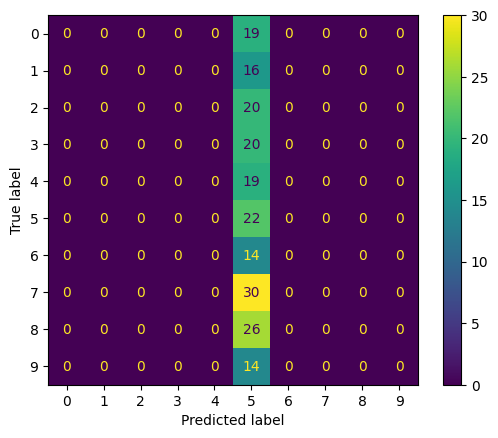

In [90]:
# visualise confusion matrix
cm = confusion_matrix(all_targets, all_preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()
